#  Importing The data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

 94% 209M/222M [00:02<00:00, 101MB/s]
100% 222M/222M [00:02<00:00, 98.3MB/s]


In [ ]:
!unzip '/content/face-mask-detection.zip'

# Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array

2023-02-20 10:50:17.546038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 10:50:17.708022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 10:50:17.708045: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 10:50:18.420511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
# len(list(data.glob('**/*.jpe')))

In [ ]:
data_dir = Path(r'/content/Dataset')

data_filepath = list(data_dir.glob('**/*.png'))

In [ ]:
data_filepath[:10]

[PosixPath('/content/Dataset/mask_weared_incorrect/21.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/423.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/105.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/721.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/2206.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/1210.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/1755.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/1012.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/1541.png'),
 PosixPath('/content/Dataset/mask_weared_incorrect/20.png')]

In [ ]:
# creating a dataframe of filepaths and labels

def image_process(filepath):
    labels = [str(i).split('/')[-2] for i in filepath]

    labels = pd.Series(labels,name='labels').astype('str')

    filepath = pd.Series(filepath,name='filepath').astype('str')

    df = pd.concat([filepath,labels],axis=1).reset_index(drop=True)

    return df
                         
                        

In [ ]:
data_df = image_process(data_filepath)

In [ ]:
# [str(i).split('\\')[-2] for i in data_filepath[:4]]

In [ ]:
data_df.head()

,filepath,labels
0,/content/Dataset/mask_weared_incorrect/21.png,mask_weared_incorrect
1,/content/Dataset/mask_weared_incorrect/423.png,mask_weared_incorrect
2,/content/Dataset/mask_weared_incorrect/105.png,mask_weared_incorrect
3,/content/Dataset/mask_weared_incorrect/721.png,mask_weared_incorrect
4,/content/Dataset/mask_weared_incorrect/2206.png,mask_weared_incorrect


# Splitting the data into train,test and val

In [ ]:
train_df = data_df.sample(frac=0.7).reset_index(drop=True)

In [ ]:
len(train_df)

6287

In [ ]:
test_df = data_df.sample(frac=0.3).reset_index(drop=True)

In [ ]:
val_df = data_df.sample(frac=0.2).reset_index(drop=True)

In [ ]:
print(len(train_df),len(test_df),len(val_df))

6287 2695 1796


In [ ]:
data_plt = data_df.sample(30)

In [ ]:
data_plt.head()

,filepath,labels
8589,/content/Dataset/with_mask/449.png,with_mask
3929,/content/Dataset/without_mask/1745.png,without_mask
7328,/content/Dataset/with_mask/247.png,with_mask
8168,/content/Dataset/with_mask/461.png,with_mask
6082,/content/Dataset/with_mask/399.png,with_mask


# Visualizing the images and labels in the DataFrame

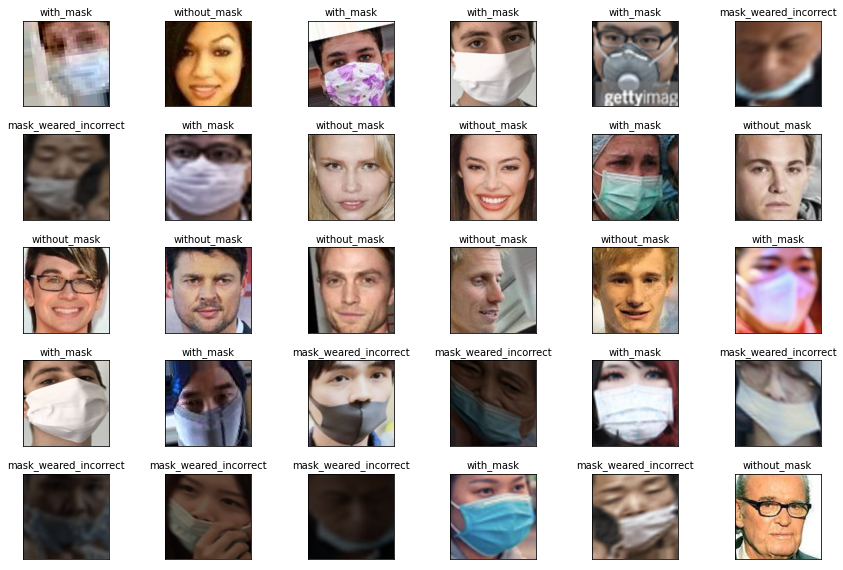

In [ ]:
fig,axes = plt.subplots(nrows=5,ncols=6,figsize=(12,8),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    img = load_img(data_plt.iloc[i][0])
    ax.imshow(img)
    ax.set_title(data_plt.iloc[i][1],fontsize=10)

plt.tight_layout(pad=1)
plt.show()

# Applying Image Augmentation

In [ ]:
train_data_aug = ImageDataGenerator(rescale=1/255.,horizontal_flip=True,zoom_range=0.3,shear_range=0.2)

In [ ]:
train_gen = train_data_aug.flow_from_dataframe(train_df,x_col='filepath', y_col='labels',
                                               target_size=(224,224),color_mode='rgb',
                                               classmode='categorical',batchsize=32,
                                               shuffle=True)

Found 6287 validated image filenames belonging to 3 classes.


In [ ]:
test_data_aug = ImageDataGenerator(rescale=1/255.)

In [ ]:
test_gen = test_data_aug.flow_from_dataframe(test_df, x_col='filepath',y_col='labels',target_size=(224,224),
                                             batch_size=32,color_mode='rgb',class_mode='categorical',shuffle=True)

Found 2695 validated image filenames belonging to 3 classes.


In [ ]:
val_data_aug = ImageDataGenerator(rescale=1/255.)

In [ ]:
val_gen = val_data_aug.flow_from_dataframe(val_df, x_col='filepath',y_col='labels',target_size=(224,224),
                                             batch_size=32,color_mode='rgb',class_mode='categorical',shuffle=True)

Found 1796 validated image filenames belonging to 3 classes.


# Building tensorflow model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32,(3,3),input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
history = model.fit(train_gen,validation_data=test_gen,epochs=20,callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0.0001,patience=5,verbose=1,mode='auto',restore_best_weights=True
)])

Epoch 1/20
197/197 [==============================] - 80s 396ms/step - loss: 0.5032 - accuracy: 0.7948 - val_loss: 0.2881 - val_accuracy: 0.8954
Epoch 2/20
197/197 [==============================] - 76s 387ms/step - loss: 0.3090 - accuracy: 0.8930 - val_loss: 0.2123 - val_accuracy: 0.9336
Epoch 3/20
197/197 [==============================] - 78s 393ms/step - loss: 0.2304 - accuracy: 0.9198 - val_loss: 0.1463 - val_accuracy: 0.9521
Epoch 4/20
197/197 [==============================] - 77s 392ms/step - loss: 0.2054 - accuracy: 0.9272 - val_loss: 0.1165 - val_accuracy: 0.9625
Epoch 5/20
197/197 [==============================] - 78s 396ms/step - loss: 0.1657 - accuracy: 0.9396 - val_loss: 0.1189 - val_accuracy: 0.9599
Epoch 6/20
197/197 [==============================] - 78s 395ms/step - loss: 0.1528 - accuracy: 0.9426 - val_loss: 0.0867 - val_accuracy: 0.9681
Epoch 7/20
197/197 [==============================] - 77s 392ms/step - loss: 0.1206 - accuracy: 0.9582 - val_loss: 0.0928 - val_ac

# Visualizing the training loss and accuracy metrics

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'Training accuracy')

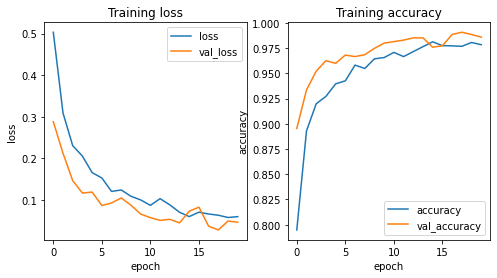

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(8,4))

ax1.plot(loss,label='loss')
ax1.plot(val_loss,label='val_loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.set_title('Training loss')


ax2.plot(accuracy, label='accuracy')
ax2.plot(val_accuracy, label='val_accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend()
ax2.set_title('Training accuracy')


# Saving the Model

In [ ]:
model.save('face_detect.h5')

# Evaluation on validation data

In [ ]:
pred = model.predict(val_gen)

57/57 [==============================] - 4s 68ms/step


In [ ]:
pred

array([[3.57115321e-04, 2.11923737e-02, 9.78450477e-01],
       [9.83655482e-05, 1.20541197e-03, 9.98696268e-01],
       [9.99892712e-01, 9.82627389e-05, 9.04888748e-06],
       ...,
       [8.94790590e-01, 8.55709543e-04, 1.04353696e-01],
       [1.07249095e-16, 3.76321339e-08, 1.00000000e+00],
       [1.72328622e-08, 1.00000000e+00, 4.72077559e-08]], dtype=float32)

In [ ]:
label = train_gen.class_indices

In [ ]:
label

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
label = dict((v,k) for k,v in label.items())

In [ ]:
prediction = np.argmax(pred,axis=1)

In [ ]:
prediction

array([2, 2, 0, ..., 0, 2, 1])

In [ ]:
len(prediction)

1796

In [ ]:
y_predict = [label[i] for i in prediction]

# Model Evaluation on Real life data

In [28]:
from tensorflow.keras.models import load_model
model = load_model('face_mask.h5')


def output(filepath):
  image_rgb = load_img(filepath,target_size=(224,224,3))
  img_array = img_to_array(image_rgb)
  img_rescaled = img_array/255
  img_expanded = np.expand_dims(img_rescaled,[0])
  pred_array = model.predict(img_expanded)
  pred_index = int(np.argmax(pred_array))
  res = label[pred_index]
  plt.imshow(image_rgb)
  plt.title(res)
  plt.axis('off')
  plt.show()


In [7]:
label = {0:'mask_weared_incorrect', 1:'with_mask', 2:'without_mask'}

In [37]:
data_validation_path = Path('Dataset')
datas = list(data_validation_path.glob('**/*.png'))

1/1 [==============================] - 0s 47ms/step


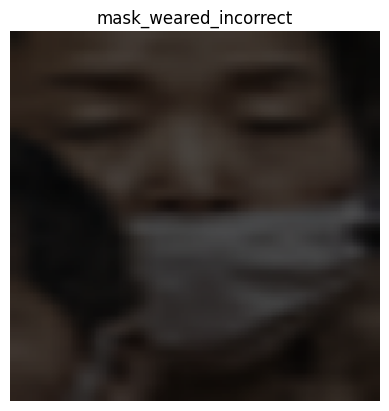

In [48]:
i = random.randint(0,len(datas))
output(datas[i])